<a href="https://colab.research.google.com/github/anirbanghoshsbi/.github.io/blob/master/work/err/Untitled192.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pyotp --q
!pip install smartapi-python==1.4.1 --q
!pip install logzero --q

In [2]:
# --- indicator look-backs / thresholds ---
SHORT   = 20          # short channel
MEDIUM  = 50          # medium channel
VOL_MA  = 20          # volume average
BB_LEN  = 20; BB_STD  = 2
ATR_LEN = 14
RANGE_MA = 10         # for compression test
EXPANSION_MULT   = 1.50   # > = expansion
CONTRACTION_MULT = 0.75   # < = contraction


In [8]:
# package import statement
from SmartApi import SmartConnect #or from SmartApi.smartConnect import SmartConnect
import pyotp
from logzero import logger
import time
import os
import urllib
import json
import pandas as pd
import datetime as dt
import numpy as np
api_key = 'xOHnB7MG'
username = 'M55123447'
pwd = '1471'
smartApi = SmartConnect(api_key)
try:
    token = "GJZACUQI2TTAIBHBA34XNFJURQ"
    totp = pyotp.TOTP(token).now()
except Exception as e:
    logger.error("Invalid Token: The provided token is not valid.")
    raise e

correlation_id = "abcde"
data = smartApi.generateSession(username, pwd, totp)

if data['status'] == False:
    logger.error(data)

else:
    # login api call
    # logger.info(f"You Credentials: {data}")
    authToken = data['data']['jwtToken']
    refreshToken = data['data']['refreshToken']
    # fetch the feedtoken
    feedToken = smartApi.getfeedToken()
    # fetch User Profile
    res = smartApi.getProfile(refreshToken)
    smartApi.generateToken(refreshToken)
    res=res['data']['exchanges']
#Download Nifty50 Index Data
params = {
           "exchange": "NSE",
           "symboltoken": '99926000',
           "interval": "ONE_DAY",
           "fromdate": (dt.datetime(2019, 3, 7).strftime('%Y-%m-%d %H:%M')),
           "todate": (dt.datetime.today().strftime('%Y-%m-%d %H:%M'))
         }
nifty_data = smartApi.getCandleData(params)
nifty_data_format= pd.DataFrame(nifty_data["data"],
                               columns = ["Date","Open","High","Low","Close","Volume"])
nifty_data_format.set_index("Date",inplace=True)
nifty_data_format.index = pd.to_datetime(nifty_data_format.index)
nifty_data_format.index = nifty_data_format.index.tz_localize(None)

In [13]:
# 2. Indicator & scoring helper
# ================================================================
def score_stock(df):
    """
    df : single-symbol daily frame (already date-sorted)
    Returns df with bull_flag, bear_flag, bull_score, bear_score
    """
    # ---- moving volume mean ----
    df["vol_ma"] = df.Volume.rolling(VOL_MA).mean()

    # ---- rolling channel highs / lows (shifted so breakout uses previous bars) ----
    df["short_hi"] = df.High.rolling(SHORT).max().shift(1)
    df["short_lo"] = df.Low. rolling(SHORT).min().shift(1)
    df["med_hi"]   = df.High.rolling(MEDIUM).max().shift(1)
    df["med_lo"]   = df.Low. rolling(MEDIUM).min().shift(1)

    # ---- Bollinger bands ----
    m  = df.Close.rolling(BB_LEN).mean()
    sd = df.Close.rolling(BB_LEN).std()
    df["bb_upper"] = m + BB_STD*sd
    df["bb_lower"] = m - BB_STD*sd

    # ---- True Range & ATR ----
    # ---------- ATR (Average True Range) ----------
    prev_close = df['Close'].shift(1)

    # 1. three true-range components, each a Pandas Series
    tr_high_low = df['High'] - df['Low']
    tr_high_pc  = (df['High'] - prev_close).abs()
    tr_low_pc   = (df['Low']  - prev_close).abs()

    # 2. take the row-wise maximum → still a Series
    tr = pd.concat([tr_high_low, tr_high_pc, tr_low_pc], axis=1).max(axis=1)

    # 3. rolling mean for ATR
    df['atr'] = tr.rolling(ATR_LEN, min_periods=1).mean()   # min_periods avoids NaNs at start

    # ---- Range compression / expansion ----
    rng     = df.High - df.Low
    rng_ma  = rng.rolling(RANGE_MA).mean()
    df["vol_exp_up"] = (
        (rng >  rng_ma * EXPANSION_MULT) &      # big range today
        (rng.shift(1) < rng_ma.shift(1) * CONTRACTION_MULT) &  # small yesterday
        (df.Close > df.Close.shift(1))          # up-close
    )
    df["vol_exp_dn"] = (
        (rng >  rng_ma * EXPANSION_MULT) &
        (rng.shift(1) < rng_ma.shift(1) * CONTRACTION_MULT) &
        (df.Close < df.Close.shift(1))          # down-close
    )

    # ============================================================
    # 3. Five bullish / bearish tests
    # ============================================================
    df["sig1_bull"] = (df.Close > df.short_hi) & (df.Volume > df.vol_ma)
    df["sig1_bear"] = (df.Close < df.short_lo) & (df.Volume > df.vol_ma)

    df["sig2_bull"] = df.Close > df.med_hi
    df["sig2_bear"] = df.Close < df.med_lo

    df["sig3_bull"] = df.Close > df.bb_upper
    df["sig3_bear"] = df.Close < df.bb_lower

    df["sig4_bull"] = df.vol_exp_up
    df["sig4_bear"] = df.vol_exp_dn

    channel_mid = (df.short_hi + df.short_lo) / 2      # mid of SHORT channel
    df["sig5_bull"] = (df.Close > channel_mid) & (df.atr > df.atr.shift(1))
    df["sig5_bear"] = (df.Close < channel_mid) & (df.atr > df.atr.shift(1))
    return df

In [14]:
nifty_final=score_stock(nifty_data_format)

In [15]:
nifty_final.tail()

,Open,High,Low,Close,Volume,vol_ma,short_hi,short_lo,med_hi,med_lo,...,sig1_bull,sig1_bear,sig2_bull,sig2_bear,sig3_bull,sig3_bear,sig4_bull,sig4_bear,sig5_bull,sig5_bear
Date,,,,,,,,,,,,,,,,,,,,,
2025-07-01,25551.35,25593.40,25501.80,25541.8,0,0.0,25669.35,24473.0,25669.35,23847.85,...,False,False,False,False,False,False,False,False,False,False
2025-07-02,25588.30,25608.10,25378.75,25453.4,0,0.0,25669.35,24473.0,25669.35,23847.85,...,False,False,False,False,False,False,False,False,False,False
2025-07-03,25505.10,25587.50,25384.35,25405.3,0,0.0,25669.35,24473.0,25669.35,23847.85,...,False,False,False,False,False,False,False,False,False,False
2025-07-04,25428.85,25470.25,25331.65,25461.0,0,0.0,25669.35,24473.0,25669.35,23847.85,...,False,False,False,False,False,False,False,False,False,False
2025-07-07,25450.45,25489.80,25407.25,25461.3,0,0.0,25669.35,24473.0,25669.35,23847.85,...,False,False,False,False,False,False,False,False,False,False


In [16]:
# ---- score & flags ----
bull_cols = ["sig1_bull","sig2_bull","sig3_bull","sig4_bull","sig5_bull"]
bear_cols = ["sig1_bear","sig2_bear","sig3_bear","sig4_bear","sig5_bear"]

nifty_final["bull_score"] = nifty_final[bull_cols].sum(axis=1)
nifty_final["bear_score"] = nifty_final[bear_cols].sum(axis=1)

nifty_final["bull_flag"] = nifty_final.bull_score >= 2
nifty_final["bear_flag"] = nifty_final.bear_score >= 2

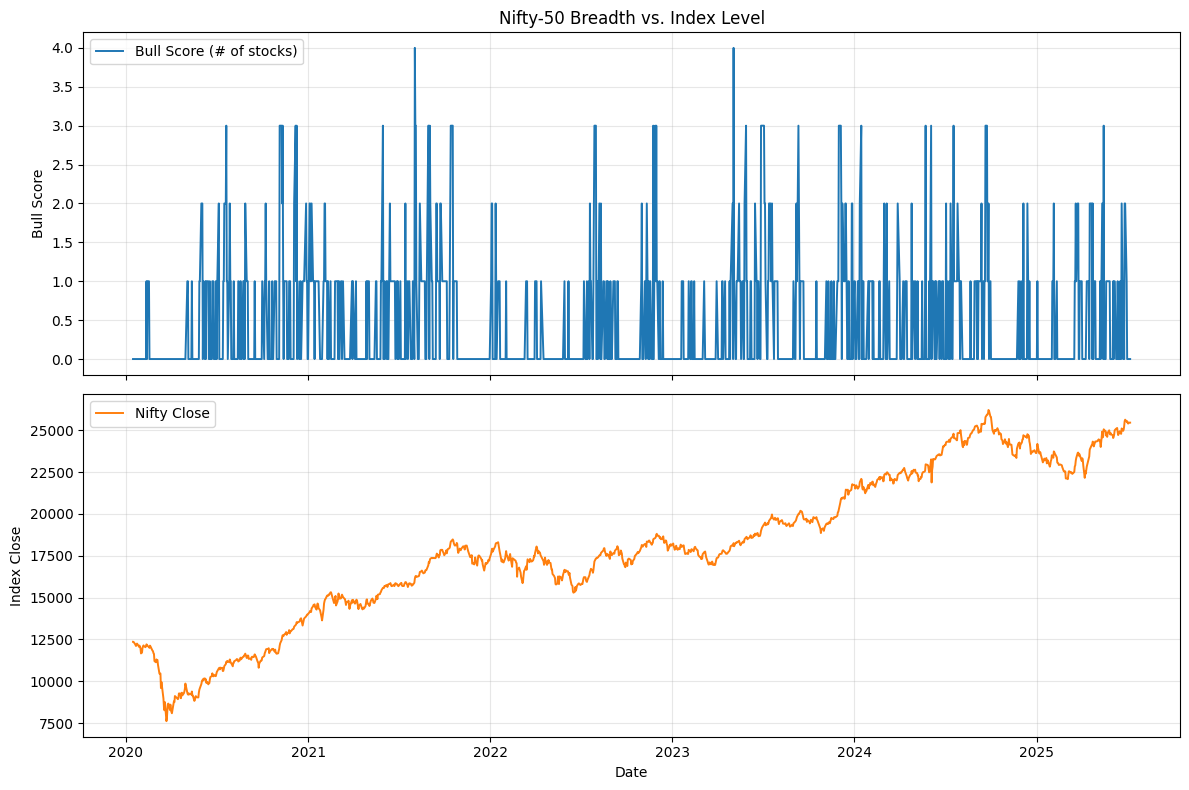

In [26]:
import matplotlib.pyplot as plt


# ---  two stacked plots sharing the x-axis  ----------------------
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(12, 8))

# 1) Bull score
axes[0].plot(nifty_final.index, nifty_final['bull_score'], label='Bull Score (# of stocks)', linewidth=1.4)
axes[0].set_ylabel('Bull Score')
axes[0].set_title('Nifty-50 Breadth vs. Index Level')
axes[0].grid(True, alpha=.3)
axes[0].legend(loc='upper left')

# 2) Nifty close
axes[1].plot(nifty_final.index, nifty_final['Close'], label='Nifty Close', linewidth=1.4, color='tab:orange')
axes[1].set_ylabel('Index Close')
axes[1].set_xlabel('Date')
axes[1].grid(True, alpha=.3)
axes[1].legend(loc='upper left')

plt.tight_layout()
plt.show()


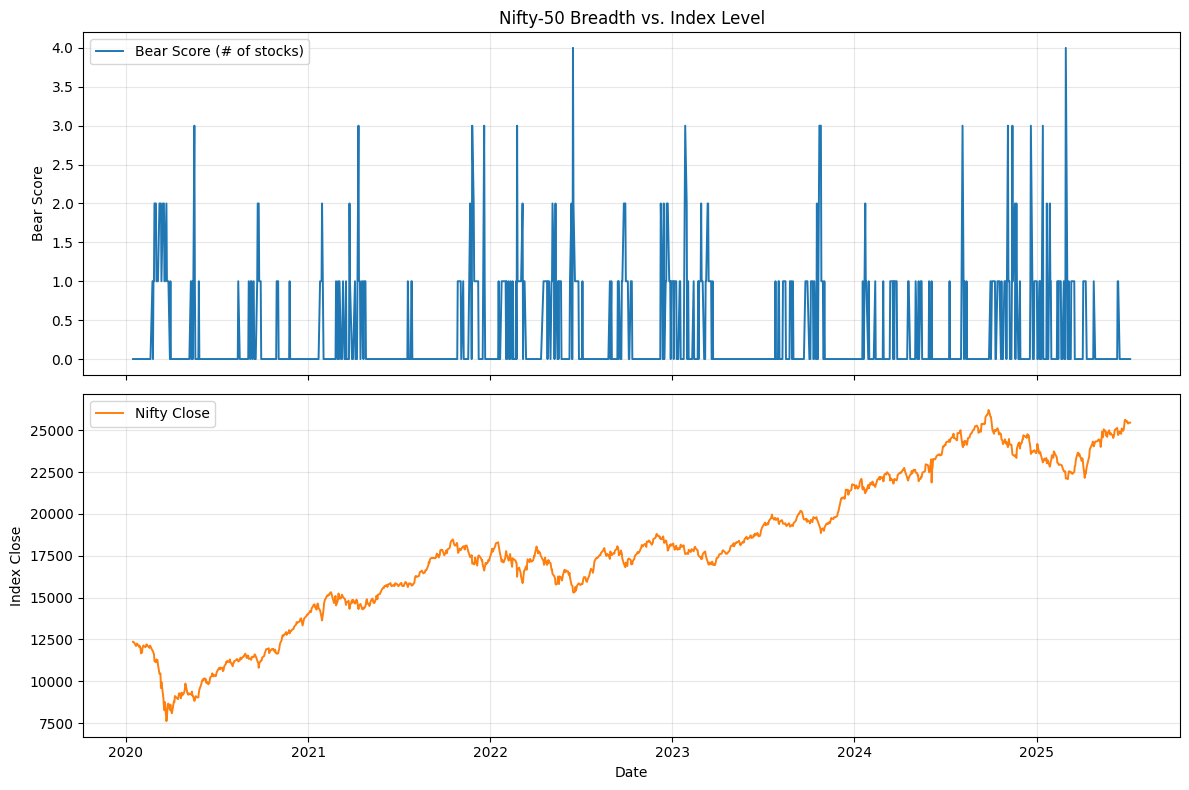

In [27]:
# ---  two stacked plots sharing the x-axis  ----------------------
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(12, 8))

# 1) Bull score
axes[0].plot(nifty_final.index, nifty_final['bear_score'], label='Bear Score (# of stocks)', linewidth=1.4)
axes[0].set_ylabel('Bear Score')
axes[0].set_title('Nifty-50 Breadth vs. Index Level')
axes[0].grid(True, alpha=.3)
axes[0].legend(loc='upper left')

# 2) Nifty close
axes[1].plot(nifty_final.index, nifty_final['Close'], label='Nifty Close', linewidth=1.4, color='tab:orange')
axes[1].set_ylabel('Index Close')
axes[1].set_xlabel('Date')
axes[1].grid(True, alpha=.3)
axes[1].legend(loc='upper left')

plt.tight_layout()
plt.show()


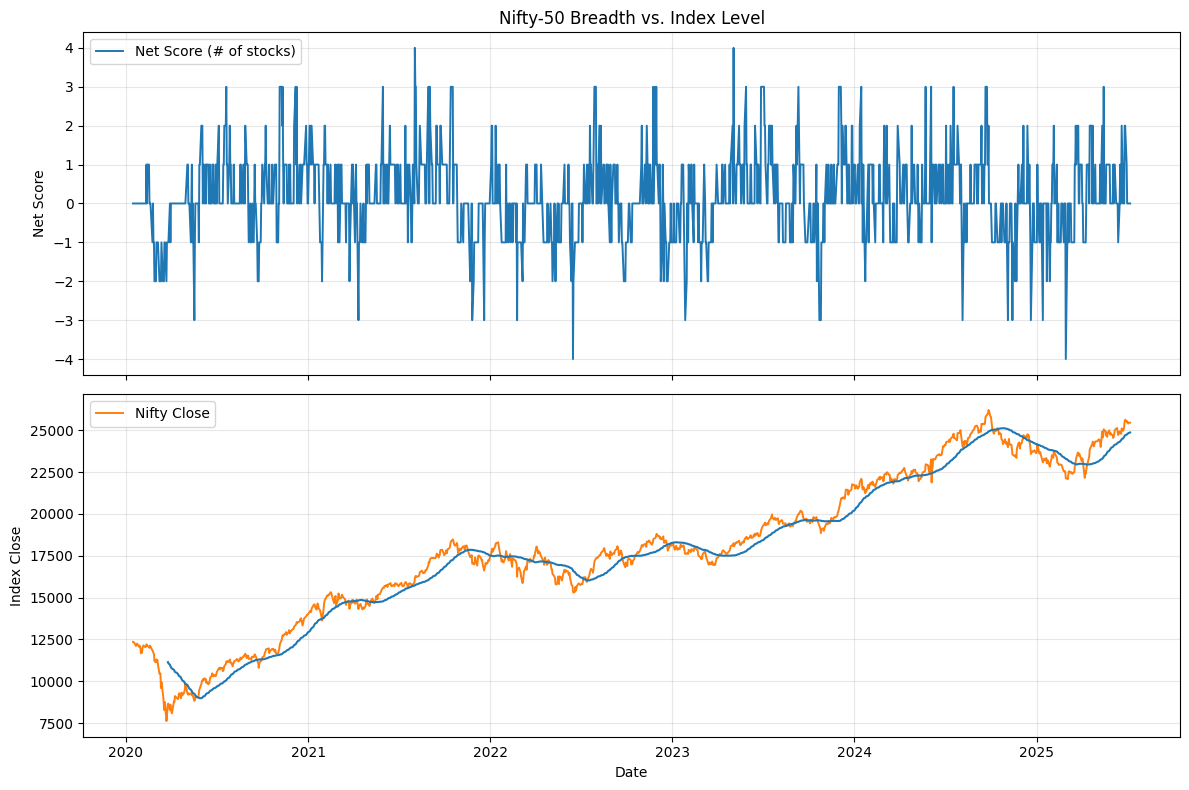

In [29]:
nifty_final['final_score']=nifty_final['bull_score']-nifty_final['bear_score']
# ---  two stacked plots sharing the x-axis  ----------------------
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(12, 8))

# 1) Bull score
axes[0].plot(nifty_final.index, nifty_final['final_score'], label='Net Score (# of stocks)', linewidth=1.4)
axes[0].set_ylabel('Net Score')
axes[0].set_title('Nifty-50 Breadth vs. Index Level')
axes[0].grid(True, alpha=.3)
axes[0].legend(loc='upper left')

# 2) Nifty close
axes[1].plot(nifty_final.index, nifty_final['Close'], label='Nifty Close', linewidth=1.4, color='tab:orange')
axes[1].plot(nifty_final.index, nifty_final['Close'].rolling(window=50).mean())
axes[1].set_ylabel('Index Close')
axes[1].set_xlabel('Date')
axes[1].grid(True, alpha=.3)
axes[1].legend(loc='upper left')

plt.tight_layout()
plt.show()
